# Functions

In this notebook I write the final versions of the functions I am using in the simulation. They are created as if they were to be used in a package.

## Module importing

In [1]:
import numpy as np
import statsmodels.api as sm
from scipy import stats
from scipy.signal import gaussian, convolve
from scipy.fftpack import fft, ifft
from scipy.optimize import minimize, fsolve
from scipy.integrate import quad

## Bandwidth selectors

### Scott's rule
I decide to implement the robust rule. I think it is safer.

$$
h_{\text{Scott}} = 1.06 A N ^ {-0.2}
$$

where $A = \min\{\hat{\sigma}, \frac{R}{1.34}\}$ is a robust measure of the dispersion in the observations. $R$ represents the inter-quartile range, defined as

$$
R = \underbrace{X_{([0.75N])}}_{\text{75% quantile}} - \underbrace{X_{([0.25N])}}_{\text{25% quantile}}
$$

In [2]:
def bw_scott(x):
    a = min(np.std(x), stats.iqr(x) / 1.34)
    bw = 1.06 * a * len(x) ** (-0.2)
    return bw

### Silverman's rule

Just as Scott's rule but the multiplying factor is 0.9 instead of 1.06

$$
h_{\text{Silverman}} = 0.9 A N ^ {-0.2}
$$

In [3]:
def bw_silverman(x):
    a = min(np.std(x), stats.iqr(x) / 1.34)
    bw = 0.9 * a * len(x) ** (-0.2)
    return bw

### Least Squares Cross-Validation

$h_{\text{LSCV}}$ is defined as the value of $h$ that minimizes

$$
\text{LSCV}(h) = \int{[\hat{f}(x; h)]^2dx} - \frac{2}{N} \sum_{i=1}^N{\hat{f}_{-i}(X_i)}
$$

In [4]:
def _get_ise_loocv(h, x, x_min, x_max):
    
    """
    Computes the Integrated Squared Error (ISE) via Leave-One-Out Cross-Validation.
    
    Parameters
    ----------
    x : numpy array
        1 dimensional array of sample data from the variable for which a 
        density estimate is desired.
    h : float
        Bandwidth (standard deviation of each Gaussian component)
    x_min : float
        Lower limit for the domain of the variable
    x_max : float
        Upper limit for the domain of the variable
  
    Returns
    -------
    lscv_error : Float, estimation of the Least Squares Cross-Validation Error.   
    """
    
    x_len = len(x)
    
    dens = sm.nonparametric.KDEUnivariate(x)
    dens.fit(kernel='gau', bw=h)
    f_squared = lambda x : dens.evaluate(x) ** 2
    
    # Compute first term of LSCV(h)
    f_sq_twice_area =  2 * quad(f_squared, x_min, x_max)[0]
    
    # Compute second term of LSCV(h)
    f_loocv_sum = 0
    for i in range(x_len):
        dens1 = sm.nonparametric.KDEUnivariate(np.delete(x, i))
        dens1.fit(kernel='gau', bw=h)
        f_loocv_sum += dens.evaluate(x[i])
    f_loocv_sum *= (2 / x_len)

    # LSCV(h)
    lscv_error = np.abs(f_sq_twice_area - f_loocv_sum)
    
    return lscv_error

def bw_lscv(x):
    """
    Computes Least Squares Cross-Validation bandwidth for a Gaussian KDE
    
    Parameters
    ----------
    x : 1-D numpy array
        1 dimensional array of sample data from the variable for which a 
        density estimate is desired.
        
    Returns
    -------
    h : float
        Bandwidth estimated via Least Squares Cross-Validation
    """
    
    x_len = len(x)
    x_std = np.std(x)
    x_min = np.min(x) - 0.5 * x_std
    x_max = np.max(x) + 0.5 * x_std   
    
    # Silverman's rule as initial value for h
    s = min(x_std, stats.iqr(x) / 1.34)
    h0 = 0.9 * s * x_len ** (-0.2)
    
    # h is constrained to be larger than 10**(-8)
    constraint = ({'type':'ineq', 'fun':lambda x : x - 10 ** (-8)})
    result = minimize(_get_ise_loocv, h0, args=(x, x_min, x_max), constraints=constraint)
    h = result.x[0]
    
    return h

### Sheather-Jones plug-in method

$h_{\text{SJ}}$ is the solution to the equation

$$
\left[\frac{R(\kappa)}{\mu_2(\kappa)^2\hat{S}(g(h))} \right] ^ {1/5} n ^{-1/5} - h = 0
$$

For a description see notebook `03_more_bandwidth_selectors`.


In [5]:
def _phi6(x):
    return (x ** 6 - 15 * x ** 4 + 45 * x ** 2 - 15) * stats.norm.pdf(x)

def _phi4(x):
    return (x ** 4 - 6 * x ** 2 + 3) * stats.norm.pdf(x)

def _sj_helper(h, s_a, t_b, x_len, x_len_mult, x_pairwise_diff):
    """
    Equation 12 of Sheather and Jones [1]
    
    References
    ----------
    .. [1] A reliable data-based bandwidth selection method for kernel
        density estimation. Simon J. Sheather and Michael C. Jones.
        Journal of the Royal Statistical Society, Series B. 1991
    """
    
    numerator = 0.375 * np.pi ** -0.5  
    g_h = 1.357 * np.abs(s_a / t_b) ** (1 / 7) * h ** (5 / 7)
    s_g = np.sum(np.sum(_phi4(x_pairwise_diff / g_h), 0))
    s_g *= x_len_mult * g_h ** -5
    
    output = (numerator / np.abs(s_g * x_len)) ** 0.2 - h
    
    return output

def bw_sj(x):
    """
    Computes Sheather-Jones bandwidth for Gaussian KDE
    
    Parameters
    ----------
    x : numpy array
        1 dimensional array of sample data from the variable for which a 
        density estimate is desired.  
    Returns
    -------
    h : float
        Bandwidth estimated via Least Squares Cross-Validation
    """
    
    x_len = len(x)
    x_std = np.std(x)
    x_iqr = stats.iqr(x)
    
    a = 0.92 * x_iqr * x_len ** (-1 / 7)
    b = 0.912 * x_iqr * x_len ** (-1 / 9) 
    
    x_len_mult = 1 / (x_len * (x_len - 1))
    x_matrix = np.tile(x, (x_len, 1))
    x_pairwise_diff = x_matrix - x_matrix.T

    t_b = np.sum(np.sum(_phi6(x_pairwise_diff / b), 0))
    t_b *= - x_len_mult * b ** -7

    s_a = np.sum(np.sum(_phi4(x_pairwise_diff / a), 0))
    s_a *= x_len_mult * a ** -5
    
    h0 = 0.9 * x_std * x_len ** (-0.2)
    
    result = fsolve(_sj_helper, h0, args=(s_a, t_b, x_len, x_len_mult, x_pairwise_diff))
    return result[0]

### Improved Sheather-Jones plug-in method

The Improved Sheather-Jones bandwidth is the *typically unique* solution to the following non-linear equation:

$$
\begin{array}{cc}
  t = \zeta\gamma^{[l]}(t), & \text{for large enough}\ l
\end{array}
$$

For a description see notebook `03_more_bandwidth_selectors`.

In [6]:
def _dct1d(x):
    """
    Discrete Cosine Transform in 1 Dimension
    
    Parameters
    ----------
    x : numpy array
        1 dimensional array of values for which the 
        DCT is desired
        
    Returns
    -------
    output : DTC transformed values
    """

    x_len = len(x)

    even_increasing = np.arange(0, x_len, 2)
    odd_decreasing = np.arange(x_len - 1, 0, -2)

    x = np.concatenate((x[even_increasing], x[odd_decreasing]))
    
    w_1k = np.r_[1, (2 * np.exp(-(0 + 1j) * (np.arange(1, x_len)) * np.pi / (2 * x_len)))]
    output = np.real(w_1k * fft(x))
    
    return output

def _idct1d(x):
    """
    Inverse Discrete Cosine Transform in 1 Dimension
    
    Parameters
    ----------
    x : numpy array
        1 dimensional array of values for which the 
        IDCT is desired
        
    Returns
    -------
    output : IDCT transformed values
    """

    x_len = len(x)

    w_2k = x * np.exp((0 + 1j) * np.arange(0, x_len) * np.pi / (2 * x_len))
    x = np.real(ifft(w_2k))

    output = np.zeros(x_len)
    output[np.arange(0, x_len, 2, dtype=int)] = x[np.arange(0, x_len / 2, dtype=int)]
    output[np.arange(1, x_len, 2, dtype=int)] = x[np.arange(x_len - 1, (x_len / 2) - 1, -1, dtype=int)]

    return output

def _fixed_point(t, N, k_sq, a_sq):
    # This implements the function t-zeta*gamma^[l](t) in 3.23
    # To avoid prevent powers from overflowing.
    k_sq = np.asfarray(k_sq, dtype='float')
    a_sq = np.asfarray(a_sq, dtype='float')

    l = 7
    f = 0.5 * np.pi ** (2.0 * l) * np.sum(k_sq ** l * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t))

    for j in reversed(range(2, l)):
        c1  = (1 + 0.5**(j + 0.5)) / 3.0
        c2  = np.product(np.arange(1., 2. * j + 1., 2., dtype = 'float')) / (np.pi / 2) ** 0.5
        t_j = np.power((c1 * c2 / (N * f)), (2 / (3 + 2 * j)))
        f   = 0.5 * np.pi ** (2. * j) * np.sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2. * t_j) )

    out = np.abs(t - (2. * N * np.pi ** 0.5 * f) ** (-0.4))
    return out

def bw_isj(x):
    
    x_len = len(x)
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = x_max - x_min
    x_std = np.std(x)
    
    grid_len = 256
    grid_min = x_min - 0.5 * x_std
    grid_max = x_max + 0.5 * x_std
       
    # Relative frequency per bin
    f, edges = np.histogram(x, bins=grid_len, range=(grid_min, grid_max))
    f = f / x_len

    # Discrete cosine transform of the data
    a_k = _dct1d(f)
    
    k_sq = np.arange(1, grid_len) ** 2
    a_sq = a_k[range(1, grid_len)] ** 2
    
    t = fsolve(_fixed_point, 0.02, args=(x_len, k_sq, a_sq))
    h = t[0] ** 0.5 * x_range
    
    return h

### Usable function

This function is a generic to call any of the bandwidth selection methods. It includes a custom method that combines Silverman's rule with the improved Sheather-Jones, which is based on a personal interest.

In [7]:
_bw_methods = {
    "scott": bw_scott,
    "silverman": bw_silverman,
    "lscv": bw_lscv,
    "sj" : bw_sj,
    "isj" : bw_isj
}

def _select_bw_method(x, method="isj"):
    method_lower = method.lower()

    if method_lower not in _bw_methods.keys():
        error_string = "Unrecognized bandwidth method.\n"
        error_string += f"Input is: {method}.\n"
        error_string += f"Expected one of: {list(_bw_methods.keys())}."
        raise ValueError(error_string)
        
    bw = _bw_methods[method_lower](x)
    return bw

def get_bw(x, bw):
    if isinstance(bw, (int, float)):
        if bw > 0:
            return bw
        else:
            error_string = "Numeric `bw` must be positive.\n"
            error_string += f"Input: {bw:.4f}."
            raise ValueError(error_string)

    elif isinstance(bw, str):
        return _select_bw_method(x, bw)
    else:
        error_string = "Unrecognized `bw` argument.\n"
        error_string += f"Input {bw} is of type {type(bw)}.\n"
        error_string += f"Expected a positive numeric or one of the following strings: {list(_bw_methods.keys())}." 
        raise ValueError(error_string)

In [8]:
x = np.random.normal(size=200)
get_bw(x, [1, 2])

ValueError: Unrecognized `bw` argument.
Input [1, 2] is of type <class 'list'>.
Expected a positive numeric or one of the following strings: ['scott', 'silverman', 'lscv', 'sj', 'isj'].

In [9]:
get_bw(x, 0)

ValueError: Numeric `bw` must be positive.
Input: 0.0000.

In [10]:
get_bw(x, "isj")

0.34844632971741485

In [11]:
get_bw(x, "Scott")

0.3604504740364906

In [12]:
get_bw(x, 0.65)

0.65

## Density estimator

### Helpers

In [18]:
from warnings import warn

def _check_type(x):
    
    if not isinstance(x, (list, np.ndarray)):
        error_str = f"`x` is of the wrong type.\n"
        error_str += f"Can't produce a density estimator for {type(x)}.\n"
        error_str += f"Please input a numeric list or numpy array."
        raise ValueError(error_str)
    
    # Will raise an error if `x` is not numeric
    x = np.asfarray(x)
    
    if x.ndim != 1:
        error_str = f"Unsupported dimension number.\n"
        error_str += f"Density estimator only works with 1-dimensional data, "
        error_str += f"not {x.ndim}."
        raise ValueError(error_str)
    
    return x

def _len_warning(x):
    if x < 50: 
        warn_str = f"The estimation may be unstable for such a few data points.\n"
        warn_str += f"Try a histogram instead."
        warn(warn_str, Warning)

### Internal estimators

In [542]:
def kde_convolution(x, bw, grid_len, grid_min, grid_max, bound_correction):
    
    # Calculate relative frequencies per bin
    f, edges = np.histogram(x, bins=grid_len, range=(grid_min, grid_max), density=True)  

    # Bandwidth must consider the bin width
    bin_width = (grid_max - grid_min) / (grid_len - 1)
    bw /= bin_width
    
    # Instantiate kernel signal
    kernel = gaussian(120, bw)
    
    if bound_correction:
        npad = int(grid_len / 4)
        f = np.concatenate([f[npad: 0: -1], f, f[grid_len : grid_len - npad : -1]])
        pdf = convolve(f, kernel, mode="same", method="direct")[npad : npad + grid_len]
        pdf = pdf / sum(kernel)
    else:
        pdf = convolve(f, kernel, mode="same", method="direct") / sum(kernel)
    
    grid = np.linspace(grid_min, grid_max, num=grid_len)
    
    return grid, pdf

def kde_adaptive(x, bw, grid_len, grid_min, grid_max, bound_correction):

    # Computations for bandwidth adjustment
    pilot_grid, pilot_pdf = kde_convolution(x, bw, grid_len, grid_min, grid_max, bound_correction)
    
    # Step 2: Determine the modification factors
    # a: Geometric mean of KDE evaluated at sample points
    # EXTREMELY important to calculate geom_mean with interpolated points
    # and `adj_factor` with `pilot_pdf`.
    pdf_interp = np.interp(x, pilot_grid, pilot_pdf)
    pilot_pdf_geom_mean = np.exp(np.mean(np.log(pdf_interp)))
    
    # b: Compute modification factors
    # Power of c = 0.5
    adj_factor = (pilot_pdf_geom_mean / pilot_pdf) ** 0.5
    bw_adj = bw * adj_factor
    
    # Estimation of Gaussian KDE via binned method (convolution not possible)
    grid_count, grid = np.histogram(x, bins=grid_len, range=(grid_min, grid_max))
    grid = (grid[1:]  + grid[:-1]) / 2
    
    if bound_correction:
        
        x_pad_min = (2 * grid_min) - grid_max
        x_pad_max = (2 * grid_max) - grid_min
        grid_pad_len = 3 * grid_len
        
        grid = np.linspace(x_pad_min, x_pad_max, num=grid_pad_len)
        grid = (grid[1:]  + grid[:-1]) / 2
        
        grid_count = np.concatenate([
            grid_count[grid_pad_len: 0: -1], 
            grid_count, 
            grid_count[grid_len : grid_len - grid_pad_len : -1]]
        )
        
        bw_adj = np.concatenate([
            bw_adj[grid_pad_len: 0: -1], 
            bw_adj, 
            bw_adj[grid_len : grid_len - grid_pad_len : -1]]
        )
        
        pdf_mat_num = np.exp(-0.5 * ((grid - grid[:, None]) / bw_adj[:, None]) ** 2) * grid_count[:, None]
        pdf_mat_den = ((2 * np.pi) ** 0.5 * bw_adj[:, None]) 
        pdf_mat = pdf_mat_num / pdf_mat_den
        pdf = np.sum(pdf_mat[:, grid_len:(2 * grid_len)], axis=0) / len(x)
        
        return grid[grid_len:(2 * grid_len)], pdf
    else:
        pdf_mat_num = np.exp(-0.5 * ((grid - grid[:, None]) / bw_adj[:, None]) ** 2) * grid_count[:, None]
        pdf_mat_den = ((2 * np.pi) ** 0.5 * bw_adj[:, None]) 
        pdf_mat = pdf_mat_num / pdf_mat_den
        pdf = np.sum(pdf_mat, axis=0) / len(x)
        
        return grid, pdf

### User accesible estimate

In [543]:
def estimate_density(
    x,
    bw="silverman",
    grid_len=256, 
    extend=True, 
    bound_correction=False, 
    adaptive=False,
    extend_fct=0.5, 
    bw_fct=1,
    bw_return=False
):
    
    # Check `x` is from appropiate type
    x = _check_type(x)
    
    # Preliminary calculations
    x_len = len(x)
    x_min = np.min(x)
    x_max = np.max(x)
    
    # Length warning:
    # Not completely sure whether it is necessary
    _len_warning(x_len)
    
    # Set up number of bins
    # Should I enable larger grids?
    if grid_len > 512:
        grid_len = 512
    if grid_len < 100:
        grid_len = 100
    grid_len = int(grid_len)
        
    # Set up domain
    # `bound_correction` overrides `extend`
    if extend and not bound_correction:
        assert isinstance(extend_fct, (int, float))
        grid_extend = extend_fct * np.std(x)
        grid_min = x_min - grid_extend
        grid_max = x_max + grid_extend
    else:
        grid_min = x_min
        grid_max = x_max
        
    # Bandwidth estimation
    assert isinstance(bw_fct, (int, float))
    bw = bw_fct * get_bw(x, bw)
    
    # Density estimation
    if adaptive:
        grid, pdf = kde_adaptive(x, bw, grid_len, grid_min, grid_max, bound_correction)
    else:
        grid, pdf = kde_convolution(x, bw, grid_len, grid_min, grid_max, bound_correction)
    
    return grid, pdf

In [544]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]

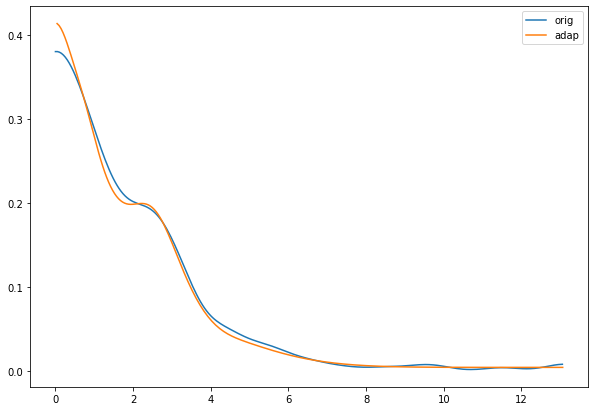

In [545]:
rvs = np.random.chisquare(2, size=200)
# rvs = np.random.normal(size=500)

x, y = estimate_density(rvs, bound_correction=True)
plt.plot(x, y, label="orig")

x, y = estimate_density(rvs, adaptive=True, bound_correction=True)
plt.plot(x, y, label="adap")
plt.legend();